## Exponentially Weighted Moving Average 

In this notebook we present a technique known as **Exponentially Weighted Moving Average (EWMA)** that is useful for reducing oscillations in SGD. 


<img src="http://engineering.unl.edu/images/uploads/SGD-No_Momentum.png" width=800 height=400>


Using EWMA we can dampen the oscillations by computing a moving/local average of the gradient (of the cost function). 

    EWMA is used in some optimization algorithms for Gradient Descent (e.g., Momentum, Adadelta, RMSprop, Adam, etc. ).


To illustrate the idea of EWMA, we use a simple noisy time-series data in which data points oscillate along the horizontal axis. We compute the moving/local average of this data to "smooth out" the oscillations.

The EWMA at time t is computed by using two factors:
- The recent past and 
- The current observation at time t 

To impose the "smoothing", the EWMA puts more weight on the past observations. To use a metaphor, past observations build up "momentum" that stabilizes the fluctuations of the current observation.

- Moving_Average(t) = weight * Past_Observations + (1 - weight) * Observation(t)

Past observations are weighted heavily by the weight parameter (denoted by $\beta$). It determines how far we go into the past to determine the present. In other words, larger $\beta$ will create increased momentum to squash out oscillations.

The fact that current moving average is determined by the past moving averages is modeled by the concept of **recursion**.

We define the following **recurrence relation** to compute the moving average $v_t$ at time t based on the past observation $v_{t-1}$ at time (t-1), and using the current observation $y_t$ at t.

$v_t = \beta*v_{t-1} + (1-\beta)*y_t$

The moving average $v_{t-1}$ at (t-1) is defined recursively, and so on.

$v_{t-1} = \beta*v_{t-2} + (1-\beta)*y_{t-1}$

$v_{t-2} = \beta*v_{t-3} + (1-\beta)*y_{t-2}$

$v_{t-3} = \beta*v_{t-4} + (1-\beta)*y_{t-3}$

...


## The Memory of Past Should Decay Exponentially!

Although the current moving average is determined by the past moving averages, we should not treat all past observations equally. We must discount the remote past, otherwise it will build a giant "momentum" that instead of smoothing out irregularities in the present, will distort the present.

Thus, as we go back in the past, we want its influence to dwindle away. This is exactly what the EWMA does. To reveal this, we have to solve the recurrence relation. We use the **backward substitution** induction technique with the initial condition $v_0 = 0$ at t = 0:

$v_t = \beta*v_{t-1} + (1-\beta)*y_t$

=> $v_t = \beta*[\beta*v_{t-2} + (1-\beta)*y_{t-1}] + (1-\beta)*y_t$

=> $v_t = \beta*\beta*v_{t-2} + \beta*(1-\beta)*y_{t-1} + (1-\beta)*y_t$

=> $v_t = \beta*\beta*[\beta*v_{t-3} + (1-\beta)*y_{t-2}] + \beta*(1-\beta)*y_{t-1} + (1-\beta)*y_t$

=> $v_t = \beta*\beta*\beta*v_{t-3} + \beta*\beta*(1-\beta)*y_{t-2} + \beta*(1-\beta)*y_{t-1} + (1-\beta)*y_t$


=> $v_t = \beta*\beta*\beta*[\beta*v_{t-4} + (1-\beta)*y_{t-3}] + \beta*\beta*(1-\beta)*y_{t-2} + \beta*(1-\beta)*y_{t-1} + (1-\beta)*y_t$


$=> v_t = \beta*\beta*\beta*\beta*v_{t-4} + \beta*\beta*\beta*(1-\beta)*y_{t-3} + \beta*\beta*(1-\beta)*y_{t-2} + \beta*(1-\beta)*y_{t-1} + (1-\beta)*y_t$

=> $v_t = \beta^4*v_{t-4} + \beta^3*(1-\beta)*y_{t-3} + \beta^2*(1-\beta)*y_{t-2} + \beta^1*(1-\beta)*y_{t-1} + \beta^0*(1-\beta)*y_t$


.........


=> $v_t = \beta^t*v_{t-t} + \beta^{t-1}*(1-\beta)*y_{t-(t-1)} + \beta^{t-2}*(1-\beta)*y_{t-(t-2)} + ... + \beta^2*(1-\beta)*y_{t-2} + \beta^1*(1-\beta)*y_{t-1} + \beta^0*(1-\beta)*y_t$



=> $ v_t =  \beta^{t-1}*(1-\beta)*y_1 + \beta^{t-2}*(1-\beta)*y_2 + ... + \beta^2*(1-\beta)*y_{t-2} + \beta^1*(1-\beta)*y_{t-1} + \beta^0*(1-\beta)*y_t$


=> $ v_t = \beta^0*(1-\beta)*y_t + \beta^1*(1-\beta)*y_{t-1} + \beta^2*(1-\beta)*y_{t-2} + ... +  \beta^{t-2}*(1-\beta)*y_2 + \beta^{t-1}*(1-\beta)*y_1 $


The solution of the recurrence relation contains two parts:
- An exponentially decaying weight function giving a diminishing series: $\beta, \beta^2, \beta^3,...$
- A series of all observations $y_t$ where t = 1, 2, 3, ...., t

Thus, $v_t$ is basically an element-wise multiplication of this two parts. Observe that the weight decays exponentially. For example, we  set $\beta = 0.9$ and get the following form of the equation:

=> $ v_t = 0.1*y_t + 0.1*0.9*y_{t-1} + 0.1*0.9^2*y_{t-2} + 0.1*0.9^3*y_{t-3} + ... +  0.1*0.9^{t-2}*y_2 + 0.1*0.9^{t-1}*y_1 $

Now it's clear that the weights in $v_t$ **decays exponentially**. It has the highest value at time $t$, then it decays exponentially into the past. At some point the weight is going to be so small that we can almost say that we "forget" that value because its contribution becomes too small to notice.

In short, to get the moving average at time $t$, we take the observation from the present at time $t$ and multiply it with the expoentially decaying function, then keep on adding it with the product of the exponential function with the past data.

Observe that the coefficient terms sum to 1 (or close to 1), as it should be.

$\beta^0*(1-\beta) + \beta^1*(1-\beta) + \beta^2*(1-\beta) + ... +  \beta^{t-2}*(1-\beta) + \beta^{t-1}*(1-\beta) $

= $(1-\beta)*[\beta^0 + \beta^1 + \beta^2 + ... +  \beta^{t-2} + \beta^{t-1}] $

$ \approx (1-\beta)* \frac{1}{1 - \beta}$ = 1

[Using the formula for the Maclaurin seris $\sum_{n=0}^\infty x^n = \frac{1}{1-x}$]


Next we will see how to control the length of the past to determine its influence on the present.


## Function to create Exponentially Weighted Moving Average (EWMA)

In [1]:
# Function to creare Exponentially Weighted Moving Average (EWMA)
def exponentially_weighted_moving_average(beta, numOfData):
    
    # a list to store the moving averages
    v = np.zeros(numOfData+1)
    
    v[0] = 0 # initial moving average should be zero
    
    i = 1
    while(i < numOfData):
        v[i] = beta*v[i-1] + (1 - beta) * y[i-1]
        i += 1
        
    return v

## Creating the EWMA for an Oscillatory Time-Series Data

We create the time-series data by using a sine function. Then, we add oscillation at each point on the function.

The EWMA smooths out the oscillations by creating a moving average.

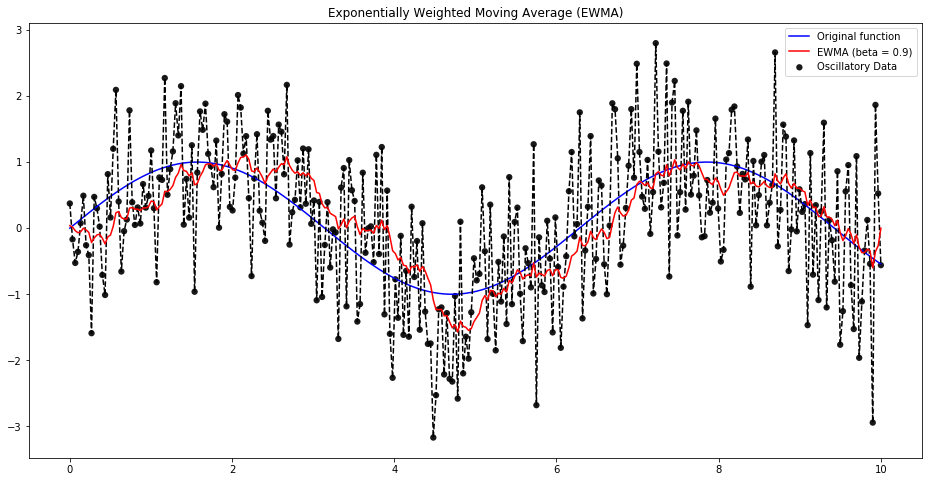

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Total number of data points
n = 300

#Create "n" data points along x axis
X = np.linspace(0,10,n) 

# Sine function with noise: Create "n" data points using a cosine function with added random normal noise
# Due to the noise there would be oscillations along x axis
y = np.zeros(n)
for i in range(n):
    y[i] = np.sin(X[i]) + np.random.normal(0, 0.9, 1)
    

# Pure Sine function: Create "n" data points using a sine function (there is no noise)
z = np.sin(X) 


# Create EWMA using a beta = 0.9
v1 = exponentially_weighted_moving_average(0.9, n)

# Plot the oscillatory data and the EWMA lines
plt.figure(figsize = (16,8))
plt.scatter(X,y,alpha=0.9, c="black", edgecolors='none', s=40, label="Oscillatory Data")
plt.plot(X,z,"b-", label="Original function")
plt.plot(X,y,"k--")
plt.plot(X,v1[1:],"r-", label="EWMA (beta = 0.9)")
plt.title("Exponentially Weighted Moving Average (EWMA)")
plt.legend(loc="best")
plt.show()

## Controling the Past to Influence the Present


When we compute the moving average we can control the number of past observations (e.g., epoch t at which we make observations) that we want to use in the calculation. It is done by the hyperparameter $\beta$.

In the following experiment, we use 3 values for $\beta$ and generate three moving averages. We have the following observation.

- Smaller value ($\beta = 0.5$): The new sequence oscillates a lot. Because we are averaging over smaller number of past observations (around 2). Therefore, it is "closer" to the noisy data.

- Larger value ($\beta = 0.98$): We get much smoother curve, but it’s a little bit shifted to the right. Because we average over larger number of observations (around 50). 

It appears that $\beta = 0.9$ provides a good balance between these two extremes, which averages over approximately past 10 observations.

Larger $\beta$ increases the weight on the past (adds more past observations). We want to understand how exactly the value of $\beta$ determines the number of past observations for computing the average.

In the following equation (solution of the EWMA recurrence relation) observe that we multuiply the past observations ($y_t$ where t = t, (t-1), (t-2), ...) by $\beta^k$ where k = 0, 1, 2, 3.

- $ v_t = \beta^0*(1-\beta)*y_t + \beta^1*(1-\beta)*y_{t-1} + + \beta^2*(1-\beta)*y_{t-2} + ... +  \beta^{t-2}*(1-\beta)*y_2 + \beta^{t-1}*(1-\beta)*y_1 $

Due to this multiplication, as we go back into the past, the influnce of past observations gets weaker if $\beta < 1$. Thus, the range of $\beta$ is set as $0 \sim 1$.

Thus, we understand that by setting $\beta$ to a suitable value we can control the length of the past observations.

Now the question is how much from the past we want to keep. 

We may define a simple heuristic: we will keep k number of past observations at which the weight of the observations reduce to 1/3 (or roughly 0.35) of it's current value. In other words, at that k the weight becomes smaller than 0.35 (or 1 / e, where e is the base of natural logarithm). Any observation beyond that threshold is not useful to account for in the averaging.

We need to find a mathematical expression for k given a value of $\beta$:

$\beta^k \approx 0.35$

Let's try 3 values of $\beta$:

- $\beta = 0.5$: It gives $(0.5)^k \approx 0.35$ => $k \approx 2$ 
- $\beta = 0.9$: It gives $(0.9)^k \approx 0.35$ => $k \approx 10$ 
- $\beta = 0.98$: It gives $(0.98)^k \approx 0.35$ => $k \approx 50$ 

Observing the 3 values of k at three $\beta$'s, we can define an expression for k:

- $k = \frac{1}{1 - \beta}$

Thus, to compute the moving average we use approximately $\frac{1}{1 - \beta}$ past observations.

However, note that this is just an estimation, not a rigorous formula.

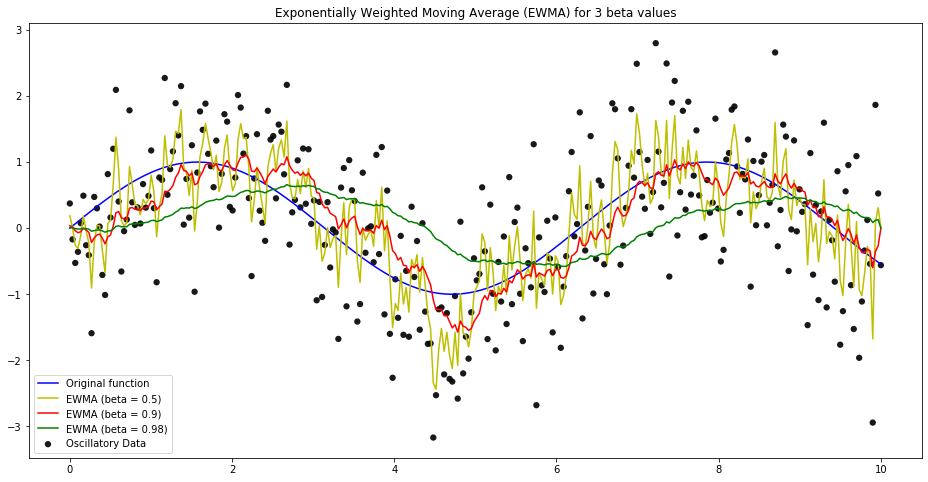

In [3]:
# Create EWMA for three different beta values
v1 = exponentially_weighted_moving_average(0.9, n)
v2 = exponentially_weighted_moving_average(0.5, n)
v3 = exponentially_weighted_moving_average(0.98, n)

# Plot the noisy data and the EWMA lines
plt.figure(figsize = (16,8))
plt.scatter(X,y,alpha=0.9, c="black", edgecolors='none', s=40, label="Oscillatory Data")
plt.plot(X,z,"b-", label="Original function")
plt.plot(X,v2[1:],"y-", label="EWMA (beta = 0.5)")
plt.plot(X,v1[1:],"r-", label="EWMA (beta = 0.9)")
plt.plot(X,v3[1:],"g-", label="EWMA (beta = 0.98)")
plt.title("Exponentially Weighted Moving Average (EWMA) for 3 beta values")
plt.legend(loc="best")
plt.show()

## EWMA: Bias Correction

In our calculation of EWMA for the noisy time-series data, we see that during the first couple of interations we don't have enough observations to compute a good average. Thus, the average would be biased initially. 

We can correct this bias as follows:

$v_t = \frac{v_t}{1 - \beta^t}$

- For small values of t, this equation will produce a little bit better results.
- With large values of t, $\beta^t$ will be indistinguishable from zero, thus not changing our values of V at all. 


When applying the EWMA in the SGD algorithm we don't need to add the bias correction part. The initial fluctuations get stabilized pretty fast.

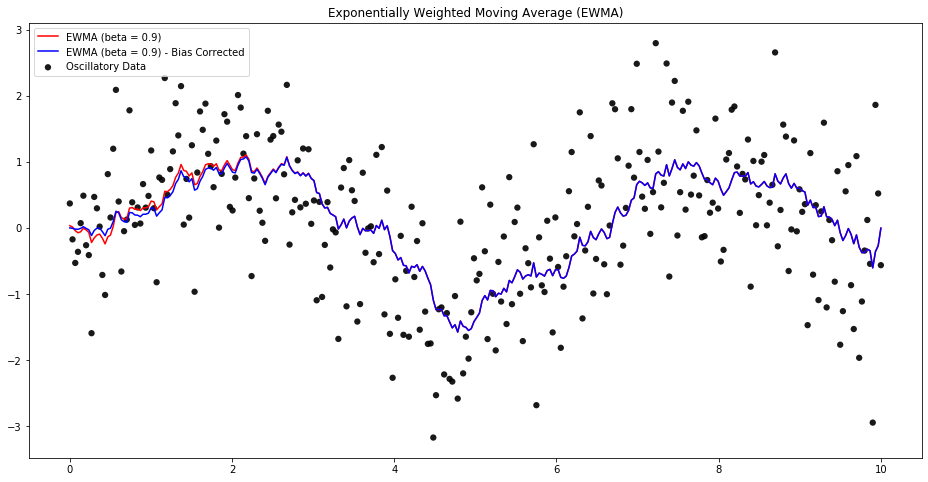

In [4]:
# Function to creare bias-corrected Exponentially Weighted Moving Average (EWMA)
def exponentially_weighted_moving_average_bias_corrected(beta, numOfData):
    # a list to store the bias-corrected moving averages
    v = np.zeros(numOfData+1)
    
    v[0] = 0 # initial moving average should be zero
    
    i = 1
    while(i < numOfData):
        v[i] = (1.0 - beta**i) * (beta*v[i-1] + (1 - beta) * y[i-1])
        i += 1
 
    return v
    

# Create both the vanilla and bias-corrected EWMA 
v1 = exponentially_weighted_moving_average(0.9, n)
v2 = exponentially_weighted_moving_average_bias_corrected(0.9, n)

# Plot the noisy data and the EWMA lines
plt.figure(figsize = (16,8))
plt.scatter(X,y,alpha=0.9, c="black", edgecolors='none', s=40, label="Oscillatory Data")
plt.plot(X,v1[1:],"r-", label="EWMA (beta = 0.9)")
plt.plot(X,v2[1:],"b-", label="EWMA (beta = 0.9) - Bias Corrected")
plt.title("Exponentially Weighted Moving Average (EWMA)")
plt.legend(loc="best")
plt.show()